In [ ]:
# ! pip install matplotlib transformers datasets opencv-python h5py

In [1]:
import numpy as np
import h5py
from datasets import Dataset, load_dataset
import pandas as pd
import cv2
import torch
import math
from matplotlib import pyplot as plt

c:\Users\ATI-G2\Envs\trans\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
f = h5py.File(r"data\exams_part0\exams_part0.hdf5", "r")
pd_results = pd.read_csv(r"data\exams_part0\exams.csv",index_col="exam_id")

exam_id = np.delete(np.array(f["exam_id"]),np.where(np.array(f["exam_id"])==0)).tolist()

In [102]:
labels = pd_results.loc[exam_id,pd_results.columns[3:9]]

for label in labels.columns:
    labels[label] = labels[label].apply(lambda x: 1 if x==True else 0)

labels = labels.to_numpy()
# labels.head()

,1dAVb,RBBB,LBBB,SB,ST,AF
exam_id,,,,,,
590673,0,0,0,0,0,0
214626,0,0,0,0,0,0
2936711,0,0,0,0,0,0
1175521,0,0,0,0,0,0
1073151,0,0,0,0,0,0


In [8]:
class ECGSequence():
    @classmethod
    def get_train_and_val(cls, path_to_hdf5, hdf5_dset, path_to_csv, batch_size=8, val_split=0.02):
        n_samples = len(pd.read_csv(path_to_csv))
        n_train = math.ceil(n_samples*(1-val_split))
        train_seq = cls(path_to_hdf5, hdf5_dset, path_to_csv, batch_size, end_idx=n_train)
        valid_seq = cls(path_to_hdf5, hdf5_dset, path_to_csv, batch_size, start_idx=n_train)
        return train_seq, valid_seq

    def __init__(self, path_to_hdf5, hdf5_dset, path_to_csv=None, batch_size=8,
                 start_idx=0, end_idx=None):

        # Get tracings
        self.f = h5py.File(path_to_hdf5, "r")
        self.x = self.f[hdf5_dset]
        self.batch_size = batch_size
        if end_idx is None:
            end_idx = len(self.x)
        self.start_idx = start_idx
        self.end_idx = end_idx
        # self.device = device
        
        if path_to_csv is None:
            self.y = None
        else:
            exam_id = np.delete(np.array(self.f["exam_id"]),np.where(np.array(self.f["exam_id"])==0)).tolist()
            pd_results = pd.read_csv(path_to_csv,index_col="exam_id")
            labels = pd_results.loc[exam_id,pd_results.columns[3:9]]

            for label in labels.columns:
                labels[label] = labels[label].apply(lambda x: 1 if x==True else 0)

            self.y = labels.to_numpy()


    @property
    def n_classes(self):
        return self.y.shape[1]

    def __getitem__(self, idx):
        start = self.start_idx + idx * self.batch_size
        end = min(start + self.batch_size, self.end_idx)
        if self.y is None:
            return np.array(self.x[start:end, :, :])
        else:
            # return np.array(self.x[start:end, :, :]), np.array(self.y[start:end])
            return torch.Tensor(self.x[start:end, :, :]).permute(0,2,1), torch.from_numpy(self.y[start:end])
        

    def __len__(self):
        return math.ceil((self.end_idx - self.start_idx) / self.batch_size)

    def __del__(self):
        self.f.close()
    

In [11]:
train_data, val_data = ECGSequence.get_train_and_val(r"..\data\code-15\exams_part0.hdf5","tracings",r"..\data\code-15\exams.csv",batch_size=1)

torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])


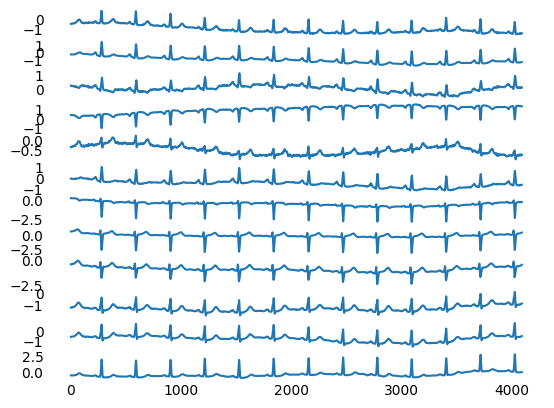

In [14]:
for data, label in train_data:
    # ax = plt.subplot(12,1,)
    for i, signal in enumerate(data[0]):
        print(signal.shape)
        plt.subplot(12,1,i+1)
        plt.plot(np.arange(0,4096), signal)

        # Turn off spines and axis ticks
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().tick_params(axis='both', which='both', length=0)

        # Remove numbers along x and y-axes
        plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
        plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
        

    plt.show()

    break

In [ ]:
import h5py
from datasets import Dataset

# Load your h5py file and extract necessary data
# Example: Replace 'features' and 'labels' with your actual data
with h5py.File('your_data.h5', 'r') as h5_file:
    features = h5_file['features'][:]
    labels = h5_file['labels'][:]

# Create a Hugging Face Dataset
dataset = Dataset.from_dict({
    'input_ids': features,
    'labels': labels,
})

# Optionally set the format to 'torch' or 'tensorflow' depending on your preference
dataset.set_format(type='torch')


In [74]:
np.array(f["tracings"])

array([[[-4.8781034e-01, -2.6677129e-01,  2.2103906e-01, ...,
         -1.1737937e+00, -5.5640870e-01, -4.8781034e-01],
        [-4.8106578e-01, -2.6019633e-01,  2.2086945e-01, ...,
         -1.1674997e+00, -5.5151391e-01, -4.8232922e-01],
        [-4.7979322e-01, -2.5791711e-01,  2.2187607e-01, ...,
         -1.1599243e+00, -5.4229915e-01, -4.7729760e-01],
        ...,
        [-1.3724924e+00, -1.2811700e+00,  9.1322273e-02, ...,
         -8.7824506e-01, -5.0396240e-01,  8.5938675e-04],
        [-1.3667058e+00, -1.2758980e+00,  9.0807825e-02, ...,
         -8.6861408e-01, -4.9709535e-01,  1.6935735e-03],
        [-1.3614640e+00, -1.2694675e+00,  9.1996796e-02, ...,
         -8.5737538e-01, -4.8235169e-01,  1.0566236e-02]],

       [[ 4.7104187e+00,  3.4908926e+00, -1.2195258e+00, ...,
         -2.7439332e-01,  6.4787310e-01,  1.1128174e+00],
        [ 4.7069054e+00,  3.4883175e+00, -1.2185876e+00, ...,
         -2.7435562e-01,  6.4121950e-01,  1.1126217e+00],
        [ 4.7019477e+00, 

In [53]:
from datasets import load_dataset

food = load_dataset('cifar10', split=['train[:5000]'])

In [54]:
food = food[0].train_test_split(test_size=0.2)

In [55]:
food["train"][0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 2}

In [56]:
labels = food["train"].features["label"].names

lable2id, id2label = {}, {}

for i, label in enumerate(labels):
    lable2id[label] = str(i)
    id2label[f"{i}"] = label


In [57]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [58]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

_transform = Compose(
    [
        RandomResizedCrop(size),
        ToTensor(),
        normalize
    ]
)

def transform(examples):
    examples["pixel_value"] = [_transform(img.convert("RGB")) for img in examples["img"]]
    del examples["img"]
    return examples

In [59]:
food = food.with_transform(transform)

In [60]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=lable2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
import torch
model.train()
with torch.no_grad():
    print(model(food["train"][0]["pixel_value"].view(-1,3,224,224)))

ImageClassifierOutput(loss=None, logits=tensor([[-0.1187,  0.1638,  0.0676,  0.0161, -0.0924,  0.0207,  0.0429, -0.0524,
         -0.0219,  0.0347]]), hidden_states=None, attentions=None)


In [67]:
from transformers import ViTModel
from torch import nn
from transformers.modeling_outputs import SequenceClassifierOutput

class ViTForImageClassification2(nn.Module):

    def __init__(self, num_labels=10):

        super(ViTForImageClassification2, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):

        outputs = self.vit(pixel_values=pixel_values)
        logits = self.classifier(outputs)
        # probs = nn.Sigmoid()
        loss = None

        if labels is not None:

          loss_fct = nn.BCEWithLogitsLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
Trainer()